In [2]:
# Import all libraries
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import warnings

warnings.filterwarnings('ignore')
np.set_printoptions(precision=4)

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset = 'drive/MyDrive/Bangkit 2022/Cleaned_Dataset.csv'

In [5]:
# Load dataset
#data = pd.read_csv('/content/UpdatedResumeDataSet.csv', engine='python')
data = pd.read_csv(dataset) # Comment this line and uncomment the above line if this does not work for you
print(len(data))
#data.head()

10501


**DROP UNNECESSARY COLUMNS**

In [6]:
data = data.drop(['salary', 'education', 'raw_description', 'experience', 'company', 'employment_type'], 1)

In [7]:
data = data.dropna()
data = data.reset_index()
data = data.drop('index', 1)
print(len(data))

9773


In [8]:
data.head()

,description,title,skills
0,Job Description\nTo implement the Head Start P...,Head Start Teacher,Emergency Handling
1,Job Description\nYou have the magic. We have t...,Teacher of English,"Vocabularies, Grammars, Teaching, Lesson Plann..."
2,Job Description\nWe are looking for a CRM deve...,CRM / PHP Developer,"PHP (Scripting Language), Debugging, Web Servi..."
3,Job Description\n\nBriggs Dodge Ram Fiat is lo...,Automotive Service Advisor / Driver,"Driving, Service Delivery, Customer Service, A..."
4,"Job Description\n HARLINGEN, TX- RIO GRANDE VA...",Licensed Nursing Home Administrator,"Emergency Handling, Training, Accounting, Heal..."


**DROP LABELS WHICH HAVING FEW SAMPLES (OPTIONAL)**

In [9]:
# Print unique categories of resumes
kategori = dict(data['title'].value_counts())
print(kategori)
print(len(kategori))

{'CUSTOMER SERVICE REPRESENTATIVE': 205, 'SALES FLOOR ASSOCIATE': 200, 'Flatbed Truck Driving Job -  ': 110, 'Sales Representative': 87, 'Retail Counter Sales': 75, 'CDL A Delivery Truck Driver  ': 67, 'Parts Delivery': 56, 'Merchandise Associate': 54, 'Customer Service Representative': 50, 'Hiring Van & Company Drivers  ': 42, 'Local CDL A Truck Driver': 42, 'Staff Accountant': 39, 'MEDICAL BILLING & CODING CAREER TRAINING ': 39, 'CDL A Truck Driver  ': 35, ' Medical Assistant': 33, 'Sales Executive  ': 33, 'Warehouse Associate': 32, 'Real Estate Agent  ': 31, 'Administrative Assistant': 30, 'CDL A Local Delivery Truck Driver  ': 30, 'Retail Merchandiser': 29, 'Sr. Accountant': 26, 'KFC Team Member': 26, 'Dental Assistant (General Dentistry Practice)': 25, 'MEDICAL ASSISTANT CAREER TRAINING - LOCAL MEDICAL TRAINING AVAILABLE': 25, 'Security Officer': 24, 'Life Insurance Agent': 24, 'Registered Nurse': 23, 'Phlebotomist': 22, 'Outside Sales Representative': 22, 'Machine Operator': 21, 

In [11]:
buang = []

for x in kategori:
  if kategori[x] < 10:
    buang.append(x)

print(buang)
print(len(buang))

['Production Worker', 'Pharmacy Technician', 'Licensed Real Estate Professional', 'Maintenance Mechanic', 'Amazon Order Filler  ', 'Sales Representative - In Person/ ', 'Retail Sales Associate', 'Data Analyst', '13J Fire Control Specialist', 'Housekeeper', 'Manufacturing Associate', 'General Labor', 'Patient Care Assistant', 'Restaurant Team Member', 'Medical Assistant', 'Restaurant General Manager', 'Account Executive', 'Project Coordinator', 'Financial Analyst', '42A Human Resources Specialist', 'Accounting Manager', '88M Truck Driver', 'Transportation Security Officer (TSO)', 'Warehouse Laborer  ', 'Maintenance Supervisor', 'Physical Therapist - Travel Contract', 'Independent Sales Representative - Part-Time/Flex Schedule', 'Assembler', 'Office Manager', "Real Estate Buyer's Agent", 'Automotive Technician', 'Receptionist', 'Paralegal', 'Real Estate Agent (Considering Real Estate for the First Time)', 'Amazon Warehouse Assistant    ', 'LOCAL CDL TRAINING AVAILABLE - TRUCK DRIVER TRAI

In [12]:
for x in buang:
  kategori.pop(x)

In [13]:
print(kategori)
print(len(kategori))

{'CUSTOMER SERVICE REPRESENTATIVE': 205, 'SALES FLOOR ASSOCIATE': 200, 'Flatbed Truck Driving Job -  ': 110, 'Sales Representative': 87, 'Retail Counter Sales': 75, 'CDL A Delivery Truck Driver  ': 67, 'Parts Delivery': 56, 'Merchandise Associate': 54, 'Customer Service Representative': 50, 'Hiring Van & Company Drivers  ': 42, 'Local CDL A Truck Driver': 42, 'Staff Accountant': 39, 'MEDICAL BILLING & CODING CAREER TRAINING ': 39, 'CDL A Truck Driver  ': 35, ' Medical Assistant': 33, 'Sales Executive  ': 33, 'Warehouse Associate': 32, 'Real Estate Agent  ': 31, 'Administrative Assistant': 30, 'CDL A Local Delivery Truck Driver  ': 30, 'Retail Merchandiser': 29, 'Sr. Accountant': 26, 'KFC Team Member': 26, 'Dental Assistant (General Dentistry Practice)': 25, 'MEDICAL ASSISTANT CAREER TRAINING - LOCAL MEDICAL TRAINING AVAILABLE': 25, 'Security Officer': 24, 'Life Insurance Agent': 24, 'Registered Nurse': 23, 'Phlebotomist': 22, 'Outside Sales Representative': 22, 'Machine Operator': 21, 

In [14]:
#print(kategori.keys())
for x in buang:
  data = data[data.title != x]

In [15]:
data = data.reset_index()

In [14]:
#data.head()

**BACK INTO THE MAIN**

In [16]:
data_size = len(data)
print(data_size)

2479


In [16]:
#data.head()

In [17]:
# Get set of stopwords
from nltk.corpus import stopwords
stopwords_set = set(stopwords.words('english')+['``',"''"])

In [18]:
# Function to clean resume text
def clean_text(text, id):
    text = str(text)
    text = re.sub('http\S+\s*', ' ', text)  # remove URLs
    text = re.sub('RT|cc', ' ', text)  # remove RT and cc
    text = re.sub('#\S+', '', text)  # remove hashtags
    text = re.sub('@\S+', '  ', text)  # remove mentions
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@
    [\]^_`{|}~"""), ' ', text)  # remove punctuations
    text = re.sub(r'[^\x00-\x7f]',r' ', text) 
    text = re.sub('\s+', ' ', text)  # remove extra whitespace
    text = text.lower()  # convert to lowercase
    if id == 1:
      text = re.sub('job', '', text)
      text = re.sub('work', '', text)
      text = re.sub('experience', '', text)
      text = re.sub('skills', '', text)
      text = re.sub('description', '', text)
      text = re.sub('requirements', '', text)
      text = re.sub('ability', '', text)
    text_tokens = word_tokenize(text)  # tokenize
    filtered_text = [w for w in text_tokens if not w in stopwords_set]
    # remove stopwords
    return ' '.join(filtered_text)

In [19]:
def clean_skills(text):
  text = text.lower()
  #text = re.sub(' ', '', text)
  text = re.sub(',', '', text)
  return text

In [20]:
# Print a sample original feature and label
print(data['skills'][1])
print(data['title'][1])

Health Facilities, Clinical Works, Registered Nurse Certified, Advanced Cardiovascular Life Support (ACLS), Nursing
Registered Nurse


In [21]:
# Clean the description
data['cleaned_skills'] = data.skills.apply(lambda x: clean_skills(x))
print(data['cleaned_skills'][1])

data['cleaned_title'] = data.title.apply(lambda x: clean_text(x, 2))
print(data['cleaned_title'][1])

health facilities clinical works registered nurse certified advanced cardiovascular life support (acls) nursing
registered nurse


In [22]:
# Get features and labels from data and shuffle
features = data['cleaned_skills'].values
#print(features)
original_labels = data['cleaned_title'].values
#print(original_labels)
labels = original_labels[:]
#print(labels)

for i in range(data_size):
  labels[i] = str(labels[i].lower())  # convert to lowercase
  labels[i] = labels[i].replace(" ", "")  # use hyphens to convert multi-token labels into single tokens
#print(labels)

import random
random.seed(20)
features, labels = shuffle(features, labels, random_state=20)

# Print example feature and label
print(features[0])
print(labels[0])

event planning operations interior design administration customer service english language typing microsoft word verbal communication sales
administrativeassistant


In [23]:
# Split for train and test
train_split = 0.8
train_size = int(train_split * data_size)

train_features = features[:train_size]
train_labels = labels[:train_size]

test_features = features[train_size:]
test_labels = labels[train_size:]

# Print size of each split
print(len(train_labels))
print(len(test_labels))

1983
496


In [24]:
# Tokenize feature data and print word dictionary
vocab_size = 3200
oov_tok = '<OOV>'

feature_tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
feature_tokenizer.fit_on_texts(train_features)

feature_index = feature_tokenizer.word_index
print(dict(list(feature_index.items())))

# Tokenize label data and print label dictionary
label_tokenizer = Tokenizer(lower=True)
label_tokenizer.fit_on_texts(labels)

label_index = label_tokenizer.word_index
print(dict(list(label_index.items())))

{'<OOV>': 1, 'customer': 2, 'sales': 3, 'service': 4, 'communication': 5, 'scheduling': 6, 'and': 7, 'management': 8, 'merchandising': 9, 'hardworking': 10, 'dedicated': 11, 'training': 12, 'unloading': 13, 'health': 14, 'retailing': 15, 'trustworthy': 16, 'accounting': 17, 'professional': 18, 'problem': 19, 'solving': 20, 'maintenance': 21, 'information': 22, 'complex': 23, 'security': 24, 'care': 25, 'restaurant': 26, 'operation': 27, 'verbal': 28, 'microsoft': 29, 'language': 30, 'science': 31, 'inventory': 32, 'to': 33, 'decision': 34, 'making': 35, 'team': 36, 'working': 37, 'passionate': 38, 'stocks': 39, 'business': 40, 'administration': 41, 'english': 42, 'services': 43, 'attention': 44, 'warehousing': 45, 'financial': 46, 'accounts': 47, 'detail': 48, 'attitude': 49, 'finance': 50, 'insurance': 51, 'protocol': 52, 'development': 53, 'driving': 54, 'coordinating': 55, 'self': 56, 'recruitment': 57, 'motivation': 58, 'benefits': 59, 'learning': 60, 'operations': 61, 'record': 62

In [25]:
# Parsing feature

parse_train_features = []
parse_train_labels = []
for x in range(len(train_features)):
  split_train_features =  train_features[x].split(' ')
  temp = ''
  for y in split_train_features:
    if temp == '':
      temp = y
    else:
      temp = temp + ' ' + y
    parse_train_features.append(temp)
    parse_train_labels.append(train_labels[x])

parse_test_features = []
parse_test_labels = []
for x in range(len(test_features)):
  split_test_features =  test_features[x].split(' ')
  temp = ''
  for y in split_test_features:
    if temp == '':
      temp = y
    else:
      temp = temp + ' ' + y
    parse_test_features.append(temp)
    parse_test_labels.append(test_labels[x])

In [26]:
print(len(train_features))
print(len(parse_train_features))
print(len(parse_train_labels))
print(len(test_features))
print(len(parse_test_features))
print(len(parse_test_labels))

1983
25843
25843
496
6410
6410


In [27]:
# Print example sequences from train and test datasets
train_feature_sequences = feature_tokenizer.texts_to_sequences(parse_train_features)
print(train_feature_sequences[0])

test_feature_sequences = feature_tokenizer.texts_to_sequences(parse_test_features)
print(test_feature_sequences[0])

[666]
[15]


In [28]:
# Print example label encodings from train and test datasets
train_label_sequences = label_tokenizer.texts_to_sequences(parse_train_labels)
print(train_label_sequences[0])

test_label_sequences = label_tokenizer.texts_to_sequences(parse_test_labels)
print(test_label_sequences[0])

[19]
[1]


In [29]:
# Pad sequences for feature data
max_length = 20
trunc_type = 'post'
pad_type = 'post'

train_feature_padded = pad_sequences(train_feature_sequences, maxlen=max_length, padding=pad_type, truncating=trunc_type)
test_feature_padded = pad_sequences(test_feature_sequences, maxlen=max_length, padding=pad_type, truncating=trunc_type)

# Print example padded sequences from train and test datasets
#print(train_feature_padded[0])
#print(test_feature_padded[0])

In [30]:
# Model
embedding_dim = 32
num_categories = len(label_index) + 1

model = tf.keras.Sequential([
  tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
  #tf.keras.layers.GlobalMaxPooling1D(),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(int(embedding_dim/2))),
  # use ReLU in place of tanh function since they are very good alternatives of each other.
  tf.keras.layers.Dense(128, activation='relu'),
  # Add a Dense layer with 25 units and softmax activation for probability distribution
  tf.keras.layers.Dense(num_categories, activation='softmax'),])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 32)            102400    
                                                                 
 bidirectional (Bidirectiona  (None, 20, 64)           16640     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 128)               4224      
                                                                 
 dense_1 (Dense)             (None, 95)                12255     
                                                                 
Total params: 145,887
Trainable params: 145,887
Non-trai

In [31]:
# Compile the model and convert train/test data into NumPy arrays
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Features
train_feature_padded = np.array(train_feature_padded)
test_feature_padded = np.array(test_feature_padded)

# Labels
train_label_sequences = np.array(train_label_sequences)
test_label_sequences = np.array(test_label_sequences)

In [32]:
# Checking
print(train_feature_padded[0])
print(train_label_sequences[0])
print(test_feature_padded[0])
print(test_label_sequences[0])

[666   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
[19]
[15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[1]


In [33]:
# Train the neural network
num_epochs = 100

history = model.fit(train_feature_padded, train_label_sequences, epochs=num_epochs, shuffle = True, validation_data=(test_feature_padded, test_label_sequences), verbose=2)

Epoch 1/100
808/808 - 20s - loss: 2.0788 - accuracy: 0.5032 - val_loss: 1.4323 - val_accuracy: 0.6521 - 20s/epoch - 25ms/step
Epoch 2/100
808/808 - 8s - loss: 0.7909 - accuracy: 0.7775 - val_loss: 1.3092 - val_accuracy: 0.7012 - 8s/epoch - 10ms/step
Epoch 3/100
808/808 - 8s - loss: 0.5982 - accuracy: 0.8225 - val_loss: 1.3038 - val_accuracy: 0.7161 - 8s/epoch - 10ms/step
Epoch 4/100
808/808 - 8s - loss: 0.5289 - accuracy: 0.8391 - val_loss: 1.2876 - val_accuracy: 0.7324 - 8s/epoch - 10ms/step
Epoch 5/100
808/808 - 8s - loss: 0.4773 - accuracy: 0.8500 - val_loss: 1.3170 - val_accuracy: 0.7309 - 8s/epoch - 10ms/step
Epoch 6/100
808/808 - 8s - loss: 0.4542 - accuracy: 0.8556 - val_loss: 1.3975 - val_accuracy: 0.7287 - 8s/epoch - 10ms/step
Epoch 7/100
808/808 - 8s - loss: 0.4307 - accuracy: 0.8607 - val_loss: 1.4313 - val_accuracy: 0.7278 - 8s/epoch - 10ms/step
Epoch 8/100
808/808 - 8s - loss: 0.4102 - accuracy: 0.8665 - val_loss: 1.5452 - val_accuracy: 0.7183 - 8s/epoch - 10ms/step
Epoch 

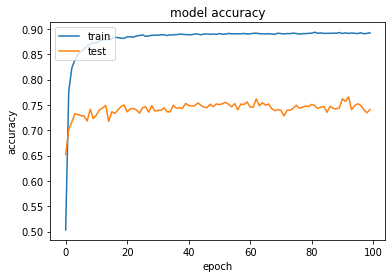

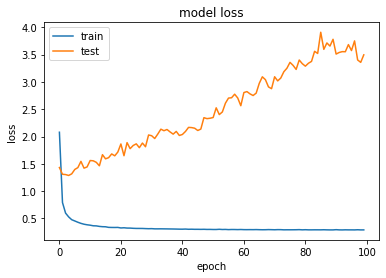

In [34]:
# Plot the training and validation loss 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**PREDICTION**

In [35]:
# Save reverse dictionary of labels to encodings
label_to_encoding = dict(list(label_index.items()))
print(label_to_encoding)

encoding_to_label = {}
for k, v in label_to_encoding.items():
  encoding_to_label[v] = k
print(encoding_to_label)

{'customerservicerepresentative': 1, 'salesfloorassociate': 2, 'flatbedtruckdrivingjob': 3, 'salesrepresentative': 4, 'retailcountersales': 5, 'cdldeliverytruckdriver': 6, 'partsdelivery': 7, 'merchandiseassociate': 8, 'localcdltruckdriver': 9, 'hiringvancompanydrivers': 10, 'medicalbillingcodingcareertraining': 11, 'staffountant': 12, 'cdltruckdriver': 13, 'medicalassistant': 14, 'salesexecutive': 15, 'warehouseassociate': 16, 'warehouseworker': 17, 'realestateagent': 18, 'administrativeassistant': 19, 'cdllocaldeliverytruckdriver': 20, 'retailmerchandiser': 21, 'amazonwarehouseattendant': 22, 'amazonwarehousingworker': 23, 'kfcteammember': 24, 'srountant': 25, 'medicalassistantcareertraininglocalmedicaltrainingavailable': 26, 'dentalassistantgeneraldentistrypractice': 27, 'lifeinsuranceagent': 28, 'securityofficer': 29, 'registerednurse': 30, 'phlebotomist': 31, 'outsidesalesrepresentative': 32, 'homecareaide': 33, 'machineoperator': 34, 'amazonwarehouseassistant': 35, 'districtsales

In [66]:
# Create padded sequence for example
skills = 'Warehousing'
example_sequence = feature_tokenizer.texts_to_sequences([skills])
example_padded = pad_sequences(example_sequence, maxlen=max_length, padding=pad_type, truncating=trunc_type)
example_padded = np.array(example_padded)
print(example_padded)

[[45  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


In [67]:
# Make a prediction
prediction = model.predict(example_padded)

In [68]:
# Verify that prediction has correct format
print(prediction[0])
print(len(prediction[0]))  
print(np.sum(prediction[0]))  # should be 1

[2.5235e-07 6.5385e-05 1.3418e-10 7.2131e-11 8.2804e-04 3.5587e-05
 2.4871e-08 2.1366e-05 3.1756e-06 4.4286e-08 9.8716e-05 2.4211e-06
 5.5486e-05 3.2089e-08 1.9246e-07 6.9280e-08 2.5007e-01 1.0290e-01
 9.0683e-07 4.4338e-04 5.1832e-08 2.8371e-06 1.7654e-01 4.1581e-02
 3.4605e-16 2.0794e-06 5.1272e-09 6.8010e-06 3.6170e-07 1.7781e-10
 1.1012e-03 1.2710e-10 6.5677e-04 3.6367e-06 1.5511e-03 2.3422e-05
 1.1397e-05 2.0953e-08 2.1545e-04 2.1077e-05 1.1442e-04 4.1227e-02
 3.5435e-02 5.9062e-09 8.6844e-04 6.2929e-05 3.9777e-14 2.0003e-05
 6.7713e-06 6.7565e-09 3.4692e-07 1.5462e-05 7.3132e-04 2.2091e-10
 4.4237e-07 1.3068e-04 2.7483e-08 2.2678e-06 1.6272e-04 6.4425e-05
 3.0042e-09 1.3508e-07 2.4237e-08 1.0557e-04 8.0018e-02 2.8327e-07
 9.0589e-05 2.9044e-08 3.3770e-13 5.3235e-11 9.2376e-02 4.4430e-07
 3.2380e-04 1.3066e-01 4.7192e-06 9.6317e-07 1.5028e-09 3.1379e-11
 5.3810e-08 3.0481e-06 6.6732e-11 1.4481e-10 2.7836e-07 1.0327e-04
 5.9882e-12 1.4772e-05 3.8182e-13 1.4803e-06 2.8203e-04 9.7706

In [69]:
# Find maximum value in prediction and its index
print(max(prediction[0]))  # confidence in prediction (as a fraction of 1)
print(np.argmax(prediction[0])) 

0.25006783
16


In [70]:
# Indices of top 5 most probable solutions
indices = np.argpartition(prediction[0], -5)[-5:]
indices = indices[np.argsort(prediction[0][indices])]
indices = list(reversed(indices))
print(indices)

[16, 22, 73, 17, 70]


In [71]:
for x in indices:
  print(encoding_to_label[x])

warehouseassociate
amazonwarehouseattendant
forkliftoperator
warehouseworker
orderpickerpacker


In [74]:
# Save model
model.save('Final_Model(Skill).h5')